In [11]:
# Importing necessary libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [12]:
# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pmdarima')
warnings.filterwarnings('ignore', category=FutureWarning)


In [13]:
#File paths and loading data
TSLA_PATH = "C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/portfolio-management-optimization/data/TSLA_processed.csv"
BND_PATH = "C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/portfolio-management-optimization/data/BND_processed.csv"
SPY_PATH = "C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/portfolio-management-optimization/data/SPY_processed.csv"

tsla_data = pd.read_csv(TSLA_PATH, parse_dates=['Date'], index_col='Date')
bnd_data = pd.read_csv(BND_PATH, parse_dates=['Date'], index_col='Date')
spy_data = pd.read_csv(SPY_PATH, parse_dates=['Date'], index_col='Date')


In [14]:
# Data pre-processing and exploration
tsla_data = tsla_data.asfreq('D', method='pad')
print(tsla_data.head())
print(tsla_data.describe())


                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-03  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-04  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-05  14.303333  14.433333  13.810667  14.006000  14.006000  80527500
2015-01-06  14.004000  14.280000  13.614000  14.085333  14.085333  93928500
              Open         High          Low        Close    Adj Close  \
count  3590.000000  3590.000000  3590.000000  3590.000000  3590.000000   
mean    111.334571   113.684752   108.766760   111.290609   111.290609   
std     110.079492   112.423044   107.445227   109.969222   109.969222   
min       9.488000    10.331333     9.403333     9.578000     9.578000   
25%      17.058499    17.387001    16.787333    17.127333    17.127333   
50%      25.000000    25

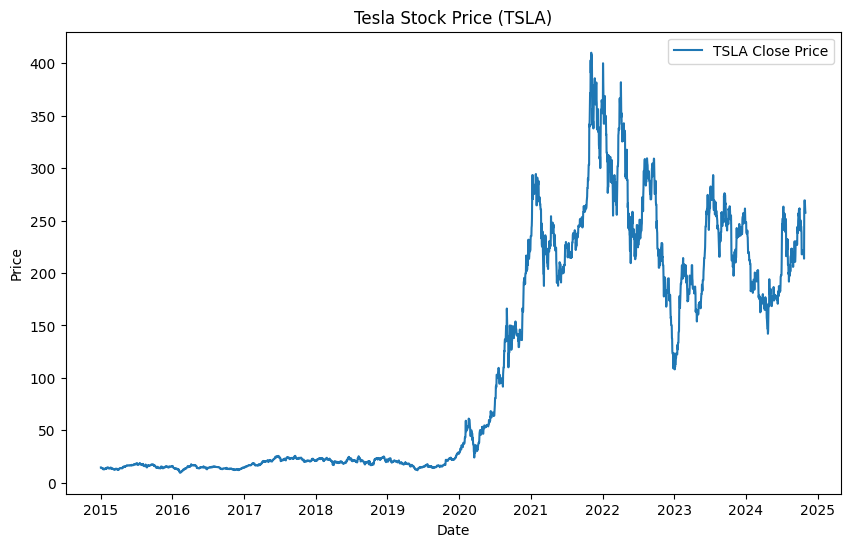

In [15]:
# Plotting TSLA closing price
plt.figure(figsize=(10, 6))
plt.plot(tsla_data['Close'], label='TSLA Close Price')
plt.title('Tesla Stock Price (TSLA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [16]:
# Prepare data for forecasting
tsla_data = tsla_data[['Close']].dropna()
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data[:train_size], tsla_data[train_size:]


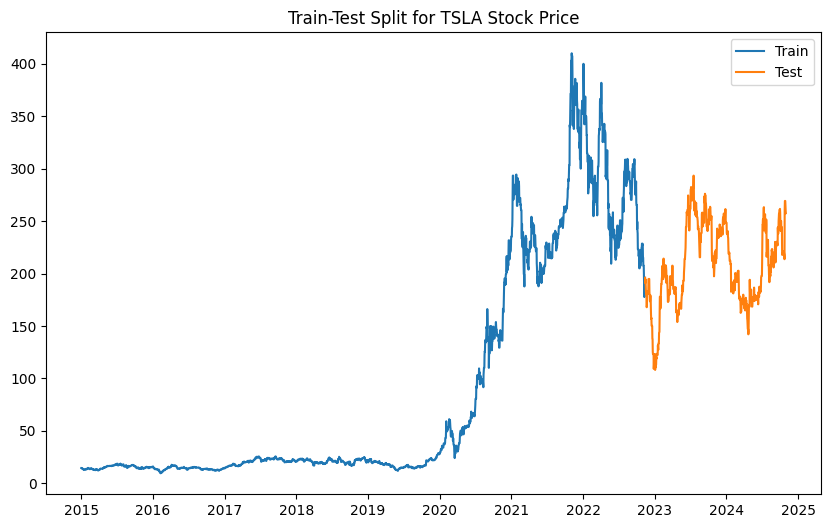

In [17]:
# Train-test split visualization
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train-Test Split for TSLA Stock Price')
plt.legend()
plt.show()


In [18]:
#Build and train ARIMA model
model_arima = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(train)
forecast_arima = pd.Series(model_arima.predict(n_periods=len(test)), index=test.index)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16854.753, Time=7.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16850.688, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16849.193, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16849.190, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16849.242, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16851.190, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16851.190, Time=1.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16853.190, Time=1.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16847.785, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16849.784, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16849.784, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16847.786, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16851.443, Time=2.45 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 16.350 seconds


In [19]:
#ARIMA model evaluation
test = test.dropna()
forecast_arima = forecast_arima.dropna()
mae = mean_absolute_error(test, forecast_arima)
rmse = np.sqrt(mean_squared_error(test, forecast_arima))
mape = mean_absolute_percentage_error(test, forecast_arima)
print(f"ARIMA Model Evaluation:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}")


ARIMA Model Evaluation:
MAE: 33.08073051888337
RMSE: 40.41134830102192
MAPE: 0.16178654022201724


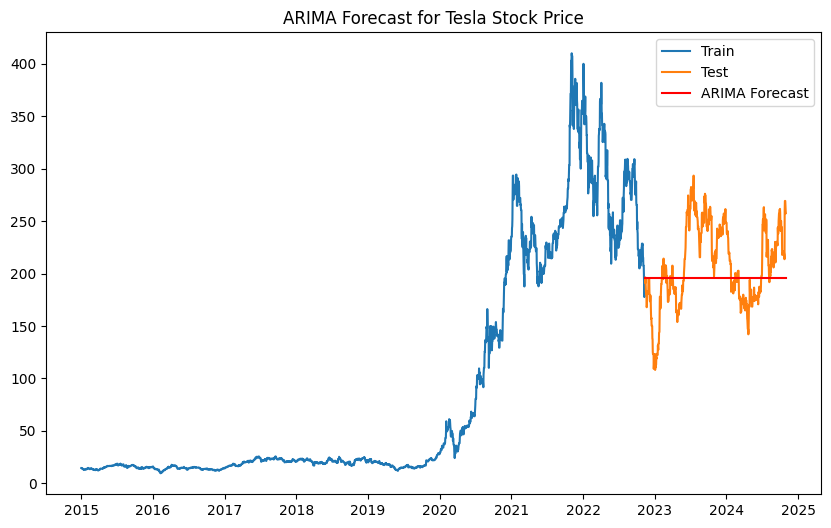

In [20]:
# ARIMA forecast visualization
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast for Tesla Stock Price')
plt.legend()
plt.show()


In [21]:
#Build and train SARIMA model
model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,5))
model_sarima_fitted = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fitted.predict(start=test.index[0], end=test.index[-1])
forecast_sarima.index = test.index


SARIMA Model Evaluation:
MAE: 32.75940241705881
RMSE: 39.00476703894523
MAPE: 0.17496220007176638


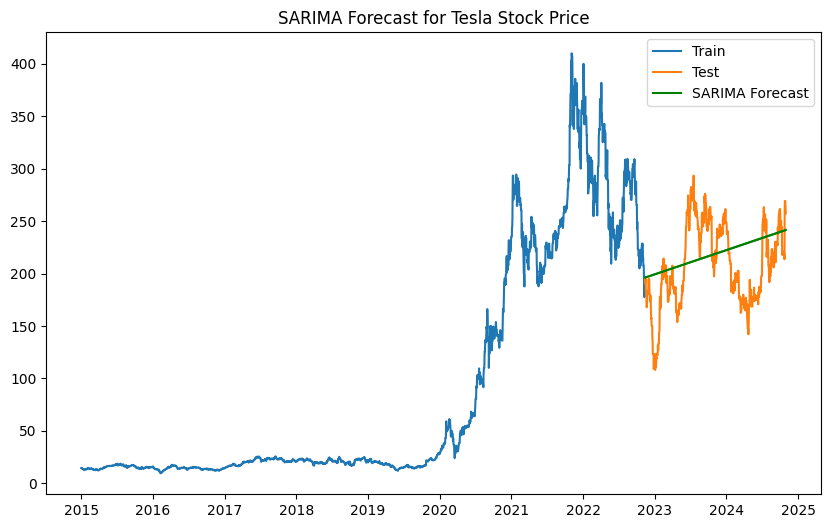

In [22]:
# SARIMA model evaluation and visualization
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
mape_sarima = mean_absolute_percentage_error(test, forecast_sarima)
print(f"SARIMA Model Evaluation:\nMAE: {mae_sarima}\nRMSE: {rmse_sarima}\nMAPE: {mape_sarima}")

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_sarima, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast for Tesla Stock Price')
plt.legend()
plt.show()


In [23]:
# Prepare data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_data)
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [24]:
# Build and train LSTM model
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)


c:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0165
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 8.5985e-04
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 8.0819e-04
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.1481e-04
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.7892e-04
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.7579e-04
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.2573e-04
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.1762e-04
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 4.1000e-04
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 4.1457e-04


In [25]:
# LSTM predictions and evaluation
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
mae_lstm = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions_lstm)
rmse_lstm = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions_lstm))
mape_lstm = mean_absolute_percentage_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions_lstm)
print(f"LSTM Model Evaluation:\nMAE: {mae_lstm}\nRMSE: {rmse_lstm}\nMAPE: {mape_lstm}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
LSTM Model Evaluation:
MAE: 8.31624545996993
RMSE: 10.922539162741405
MAPE: 0.04148243561859467


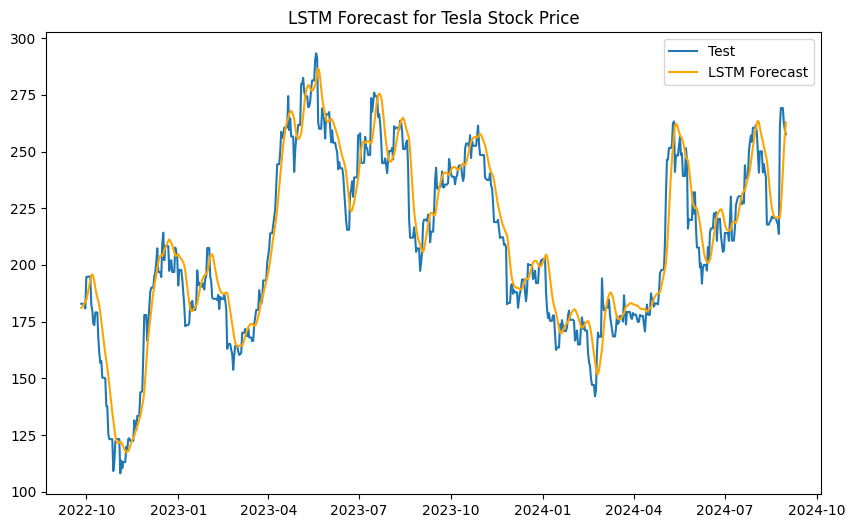

In [26]:
# LSTM forecast visualization
plt.figure(figsize=(10, 6))
test_index = tsla_data.index[train_size:train_size + len(y_test)]
plt.plot(test_index, scaler.inverse_transform(y_test.reshape(-1, 1)), label='Test')
plt.plot(test_index, predictions_lstm, label='LSTM Forecast', color='orange')
plt.title('LSTM Forecast for Tesla Stock Price')
plt.legend()
plt.show()
